<div class="alert alert-success"><h1>Augmenting Image Data in Python</h1></div>

**Image augmentation** is a fundamental technique used in deep learning to artificially expand the diversity of a training dataset without actually collecting more data. By applying transformations such as rotations, flips, color adjustments, and adding noise, we can help our models generalize better to unseen data and reduce the risk of overfitting. In this tutorial, we’ll walk through several common augmentation techniques using a small sample from the famous **Kaggle Dogs vs. Cats** dataset.

## Learning Objectives
By the end of this tutorial, you will be able to:
+ Understand the purpose and benefits of image augmentation.
+ Apply geometric transformations like rotation, flipping, cropping, translation, shearing, and zooming.
+ Perform color and intensity adjustments such as brightness, contrast, and hue shifts.
+ Introduce noise and simulate occlusion through techniques like random erasing.

## Prerequisites
Before getting started, you should have:
+ Basic knowledge of Python programming (e.g., functions, loops, packages).
+ Familiarity with `NumPy` and `Matplotlib` for array manipulation and plotting.
+ A Python environment (version 3.x) with `tensorflow`, `keras`, and `matplotlib` installed.
+ Some exposure to image data and the concept of tensors is helpful, but not required.

<hr>

The images are stored in a directory called `"train"`, with a subdirectory for cat images called `"cat"`, and another for dog images called `"dog"`. Let's begin by importing and previewing the images.

In [1]:
from keras.utils import image_dataset_from_directory

base_dir = 'train'
images = image_dataset_from_directory(
    base_dir,
    labels ='inferred',
    label_mode = 'int',
    image_size = (180, 180),
    batch_size =6,
    seed = 1
)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

Next, we define a reusable helper function `display_images()` that will help us display multiple images side-by-side for quick visual inspection. This function will take a batch of images and display them in a single row, without axes clutter, along with a custom title above the row. We'll use this function throughout the tutorial to preview both original and augmented images.

In [2]:
import matplotlib.pyplot as plt

def display_images(image_batch, title):
  plt.figure(figsize =(18,3))
  for i in range(len(image_batch)):
    ax = plt.subplot(1, len(image_batch), i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.axis('off')
  plt.suptitle(title)
  plt.show()


Now, we preview the imported and resized images using the `display_images()` function we just defined.

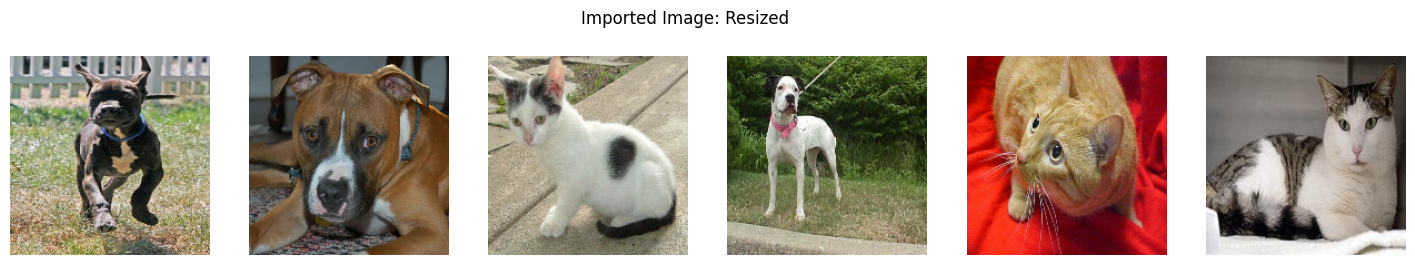

In [3]:
for image_batch, _ in images.take(1):
  display_images(image_batch, 'Imported Image: Resized')

**Note:** If you see a message at the end of the output, it isn't an error. It's just TensorFlow’s way of saying "I've delivered all the data you asked for.".

## 1. Geometric Transformations
We define a new augmentation pipeline using **Keras preprocessing layers** to apply geometric transformations that randomly flip, rotate, zoom, crop, and then resize images back to 180 by 180. Each time an image passes through this augmentation_layer, it will undergo a combination of random flips (horizontal and vertical), small rotations, slight zooms, and random cropping, all while maintaining consistent output size.

In [5]:
from tensorflow import keras
from keras import layers

augmentation_layer = keras.Sequential([
    layers.RandomFlip(mode = 'horizontal_and_vertical'),
    layers.RandomRotation(factor =0.2),
    layers.RandomZoom(0.2),
    layers.RandomCrop(height = 160, width =160),
    layers.Resizing(height = 180, width = 180)
])

Let's apply the transformations and preview the augmented images to observe the effects of geometric transformations.

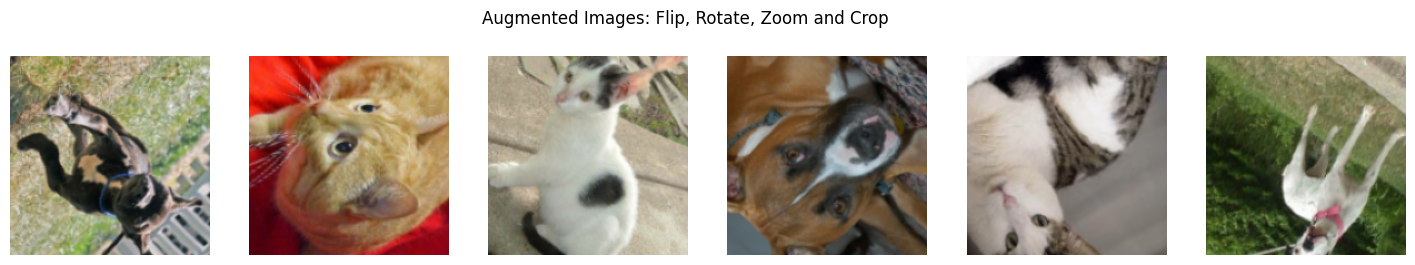

In [6]:
geom_augmented_images = images.map(lambda image, label: (augmentation_layer(image), label))

for image_batch, _ in geom_augmented_images.take(1):
  display_images(image_batch, "Augmented Images: Flip, Rotate, Zoom and Crop")

The output shows how geometric transformations can easily introduce diversity into the image dataset without changing the label of the data.

## 2. Color and Intensity Transformations
Next, we create a new augmentation pipeline that randomly adjusts the image’s brightness, contrast, saturation, and hue to simulate different lighting and color conditions.

In [7]:
augmentation_layer = keras.Sequential([
    layers.RandomColorJitter(
        value_range = (0, 255),
        brightness_factor = 0.2,
        contrast_factor = 0.3,
        saturation_factor = 0.2,
        hue_factor = 0.02,
        seed =12
    )
])

Let’s display the images after applying the color and intensity transformations.

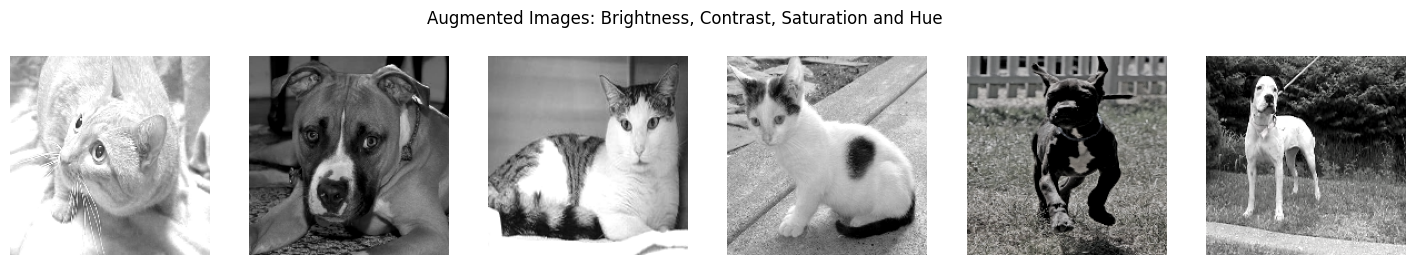

In [8]:
color_augmented_images = images.map(lambda image, label :(augmentation_layer(image), label))
for image_batch, _ in color_augmented_images.take(1):
  display_images(image_batch,"Augmented Images: Brightness, Contrast, Saturation and Hue")


As you notice, some images are slightly brighter, darker, more saturated, or have slight color tints, mimicking lighting differences a model might encounter during deployment.

## 3. Occlusion and Cutout
Here, we introduce random erasing (cutout) by randomly covering portions of the images with rectangles filled with random pixel values or black pixels. Random erasing teaches a model to rely less on any specific part of an object and instead focus on overall context, which can improve resilience against occlusion in real-world settings.

In [9]:
augmentation_layer = keras.Sequential([
    layers.RandomErasing(
        value_range = (0, 255),
        factor = 1.0,
        scale = (0.02, 0.33),
        fill_value = None,
        seed =123
    )
])

AttributeError: module 'keras.api.layers' has no attribute 'RandomErasing'

Now, let’s preview the images to see the effect of random erasing.

You can see that some parts of the images are randomly "cut out", appearing as missing patches.

## 4. Random Operations
Finally, we apply a general-purpose augmentation strategy called `RandAugment`, which randomly selects and applies two operations from a list of possible augmentations with a specified intensity. This approach helps create highly varied datasets without needing to manually specify every transformation.

Let’s preview the images augmented using the random augmentation strategy.

Since these are random augmentations, it's impossible to tell what results you'll get. However, you should see images with random variations due to the two operations chosen for each.

In this tutorial, we explored several popular image augmentation techniques that can drastically improve a model’s ability to generalize. By systematically applying geometric transformations, color adjustments, occlusions, and randomized augmentation pipelines, we make our models more resilient, better performing, and less prone to overfitting. However, it is important to note the following:
+ Image augmentation should only be applied to training data, and not to validation or test data, as we want to evaluate our model on real images in order to assess its true performance.
+ Image augmentation should also be plausible. It should not alter the image in a way that changes its class. For example, flipping an image of a traffic sign that points left to now point right, could change its meaning and may not be acceptable depending on the training objective.